# LOFAR single station imaging

Based on version 1.4 of V.A. Moss's tutorial, tutorial from M.A. Brentjens 8/8/2017.

Updated February 2020 by T.J. Dijkema with aerial imagery backdrops.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import time
import datetime
import glob
import numpy as np

from scipy import ndimage

from lofarantpos.db import LofarAntennaDatabase

In [3]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, Normalize
import warnings
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.axes as maxes
from matplotlib.ticker import FormatStrFormatter

In [4]:
from astropy.coordinates import SkyCoord, GCRS, EarthLocation, AltAz, SkyOffsetFrame, CartesianRepresentation, get_sun, get_moon
import astropy.units as u
from astropy.time import Time

In [5]:
# We need lofarantpos >= 0.4.0 to get the station rotations

from packaging import version
import lofarantpos
assert(version.parse(lofarantpos.__version__) >= version.parse("0.4.0"))

In [6]:
from lofarimaging import find_caltable, sb_from_freq, freq_from_sb, read_caltable, \
    read_acm_cube, get_map, sky_imager, ground_imager, get_station_pqr, \
    skycoord_to_lmn, nearfield_imager, make_leaflet_map, make_sky_plot

In [7]:
# We need python 3.6 for f-string formatting

assert(sys.version_info.major + 0.1*sys.version_info.minor >= 3.6)

In [8]:
data_dir = "./"
caltable_dir = "./caltables"  # Root directory under which station information is stored in subdirectories DE602C/etc/, RS106/etc/, ...
station_name = 'DE603LBA'

In [9]:
extent = [-150, 150, -150, 150]
pixels_per_metre = 0.5
height=1.5

In [10]:
if station_name[0] == "C":
    station_type = "core"
elif station_name[0] == "R" or station_name[:5] == "PL611":
    station_type = "remote"
else:
    station_type = "intl"

In [2]:
os.makedirs('results', exist_ok=True)

In [11]:
start1 = time.time()

In [12]:
# Read all available .dat files
print(f"Searching for available files in {data_dir}")
files = glob.glob(data_dir + "/*.dat")
for file_index, filename in enumerate(files):
    print(f"{file_index}: {filename}")

Searching for available files in ./
0: ./20170720_095816_mode_3_xst_sb297.dat


In [13]:
# Select a file
xst_filename = files[0]

print("File selected:", xst_filename)

File selected: ./20170720_095816_mode_3_xst_sb297.dat


In [14]:
# Distill metadata from filename
cubename = os.path.basename(xst_filename)
obsdatestr, obstimestr, _, rcu_mode, _, subbandname = cubename.rstrip(".dat").split("_")
subband = int(subbandname[2:])

# Needed for NL stations: inner (rcu_mode 3/4), outer (rcu_mode 1/2), (sparse tbd)
# Should be set to 'inner' if station type = 'intl'
array_type = None
if rcu_mode in ('1', '2'):
    array_type = 'outer'
elif rcu_mode in ('3', '4'):
    array_type = 'inner'
elif rcu_mode in ('5', '6', '7'):
    array_type = rcu_mode
else:
    raise Exception("Unexpected rcu_mode: ", rcu_mode)

# Get the data
fname = f"{obsdatestr}_{obstimestr}_{station_name}_SB{subband}"

npix_l, npix_m = 131, 131
freq = freq_from_sb(subband, rcu_mode=rcu_mode)

# Which slice in time to visualise
timestep = 0

# For ground imaging
ground_resolution = pixels_per_metre  # pixels per metre for ground_imaging, default is 0.5 pixel/metre

obstime = datetime.datetime.strptime(obsdatestr + ":" + obstimestr, '%Y%m%d:%H%M%S')

# Confirm the data has been read correctly
print(f"""Filename: {cubename}
Station: {station_name}
Station type: {station_type}
Array type: {array_type}
Subband: {subband}
Timestep: {timestep}
Save title: {fname}
Sky image size: {npix_l:d} x {npix_m:d}
Ground image extent: {extent[1]-extent[0]:d} x {extent[3]-extent[2]:d} m
Ground height: {height} m\
""")

Filename: 20170720_095816_mode_3_xst_sb297.dat
Station: DE603LBA
Station type: intl
Array type: inner
Subband: 297
Timestep: 0
Save title: 20170720_095816_DE603LBA_SB297
Sky image size: 131 x 131
Ground image extent: 300 x 300 m
Ground height: 1.5 m


In [15]:
# Read cube
cube = read_acm_cube(xst_filename, station_type)

In [16]:
caltable_filename = find_caltable(station_name, rcu_mode=array_type,
                                  config_dir=caltable_dir)

In [17]:
# Apply calibration 

if caltable_filename is None:
    print('No calibration table found... cube remains uncalibrated!')
else:
    cal_header, cal_data = read_caltable(caltable_filename)

    rcu_gains = cal_data[subband, :]
    rcu_gains = np.array(rcu_gains, dtype=np.complex64)
    gain_matrix = rcu_gains[np.newaxis, :] * np.conj(rcu_gains[:, np.newaxis])
    cube = cube / gain_matrix

In [18]:
# Split into the XX and YY polarisations (RCUs)
# This needs to be modified in future for LBA sparse
cube_xx = cube[:, 0::2, 0::2]
cube_yy = cube[:, 1::2, 1::2]
visibilities_all = cube_xx + cube_yy

# Stokes I for specified timestep
visibilities = visibilities_all[timestep]

In [19]:
# Check the resulting cubes have half the size
cube_xx.shape, cube_yy.shape, visibilities.shape, visibilities.dtype

((29, 96, 96), (29, 96, 96), (96, 96), dtype('complex128'))

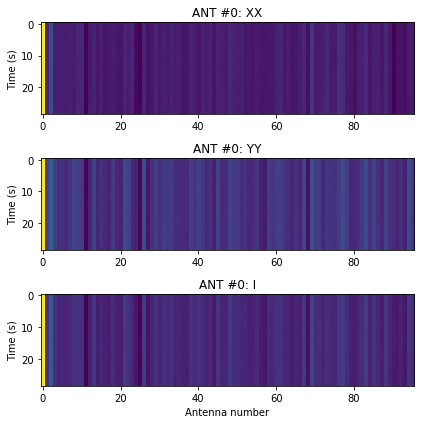

In [20]:
# Check how the various antennas/polarisation look with time
fig1, (ax0, ax1, ax2) = plt.subplots(nrows=3, ncols=1, figsize=(6,6))

ax0.imshow(cube_xx[:, 0, :].real, aspect='auto')
ax0.set_ylabel('Time (s)')
ax0.set_title('ANT #0: XX')
ax1.imshow(cube_yy[:,0,:].real,aspect='auto')
ax1.set_title('ANT #0: YY')
ax1.set_ylabel('Time (s)')
ax2.imshow(visibilities_all[:,0,:].real,aspect='auto')
ax2.set_title('ANT #0: I')
ax2.set_xlabel('Antenna number')
ax2.set_ylabel('Time (s)')
fig1.tight_layout()

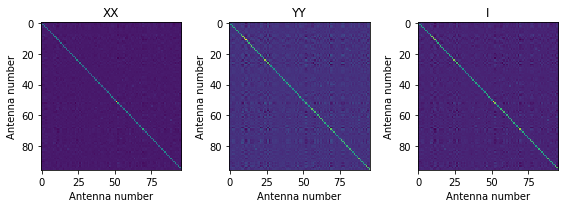

In [21]:
# Check how the correlations look
fig1, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(8,3))

ax0.imshow(cube_xx[0,:,:].real, aspect='auto')
ax0.set_xlabel('Antenna number')
ax0.set_ylabel('Antenna number')
ax0.set_title('XX')
ax1.imshow(cube_yy[0,:,:].real, aspect='auto')
ax1.set_title('YY')
ax1.set_xlabel('Antenna number')
ax1.set_ylabel('Antenna number')
ax2.imshow(visibilities.real, aspect='auto')
ax2.set_title('I')
ax2.set_xlabel('Antenna number')
ax2.set_ylabel('Antenna number')
fig1.tight_layout()

In [22]:
# Setup the database
db = LofarAntennaDatabase()

In [23]:
station_pqr = get_station_pqr(station_name, station_type, array_type, db)

In [24]:
# Rotate station_pqr to a north-oriented xyz frame, where y points North, in a plane through the station.
rotation = db.rotation_from_north(station_name)

In [25]:
pqr_to_xyz = np.array([[np.cos(-rotation), -np.sin(-rotation), 0],
                       [np.sin(-rotation),  np.cos(-rotation), 0],
                       [                0,                  0, 1]])

In [26]:
station_xyz = (pqr_to_xyz @ station_pqr.T).T

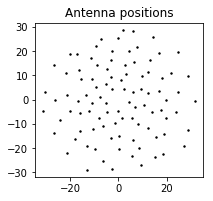

In [28]:
fig, ax = plt.subplots(figsize=(3, 3))
ax.scatter(station_xyz[:, 0], station_xyz[:, 1], s=2, facecolor='k');
ax.set_title("Antenna positions");
ax.set_aspect(1);

In [29]:
# For every antenna, calculate the distance between it and every other antenna
baselines = station_xyz[:, np.newaxis, :] - station_xyz[np.newaxis, :, :]

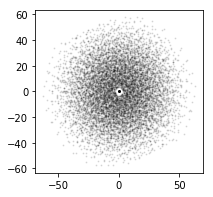

In [28]:
# Make a plot of the baselines contents (only U-V, not W)
# This gives the instantaneous U-V coverage of the LBA station
plt.figure(figsize=(3,3))
plt.scatter(baselines[:,:,0], baselines[:,:,1], facecolor='k', edgecolor='k', s=1, alpha=0.1);

In [29]:
# Account for the rotation
rotation = np.rad2deg(db.rotation_from_north(station_name))
print ('Rotation for %s: %.2f deg' % (station_name, rotation))

Rotation for DE603LBA: 3.84 deg


In [32]:
# Fourier transform
img = sky_imager(visibilities, baselines, freq, npix_l, npix_m)

In [33]:
obstime_astropy = Time(obstime)
# Determine positions of Cas A and Cyg A
station_earthlocation = EarthLocation.from_geocentric(*(db.phase_centres[station_name] * u.m))
zenith = AltAz(az=0 * u.deg, alt=90 * u.deg, obstime=obstime_astropy,
               location=station_earthlocation).transform_to(GCRS)

marked_bodies = {
    'Cas A': SkyCoord(ra=350.85*u.deg, dec=58.815*u.deg),
    'Cyg A': SkyCoord(ra=299.868*u.deg, dec=40.734*u.deg),
#        'Per A': SkyCoord.from_name("Perseus A"),
#        'Her A': SkyCoord.from_name("Hercules A"),
#        'Cen A': SkyCoord.from_name("Centaurus A"),
#        '?': SkyCoord.from_name("J101415.9+105106"),
#        '3C295': SkyCoord.from_name("3C295"),
#        'Moon': get_moon(obstime_astropy, location=station_earthlocation).transform_to(GCRS),
    'Sun': get_sun(obstime_astropy)
#        '3C196': SkyCoord.from_name("3C196")
}

marked_bodies_lmn = {}
for body_name, body_coord in marked_bodies.items():
    #print(body_name, body_coord.separation(zenith), body_coord.separation(zenith))
    if body_coord.transform_to(AltAz(location=station_earthlocation, obstime=obstime_astropy)).alt > 0:
        marked_bodies_lmn[body_name] = skycoord_to_lmn(marked_bodies[body_name], zenith)

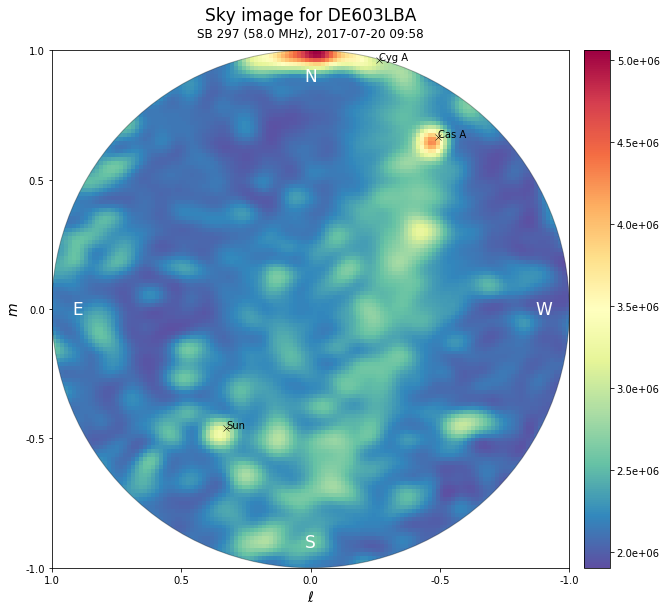

In [34]:
fig = make_sky_plot(img, marked_bodies_lmn, title=f"Sky image for {station_name}",
                    subtitle=f"SB {subband} ({freq / 1e6:.1f} MHz), {str(obstime)[:16]}");

In [35]:
fig.savefig(os.path.join('results', f'{fname}_sky_calibrated.png'), bbox_inches='tight', dpi=200)

In [36]:
plt.close(fig)

In [37]:
npix_x, npix_y = int(ground_resolution * (extent[1] - extent[0])), int(ground_resolution * (extent[3] - extent[2]))

In [34]:
os.environ["NUMEXPR_NUM_THREADS"] = "3"

In [35]:
# Select a subset of visibilities, only the lower triangular part
baseline_indices = np.tril_indices(visibilities.shape[0])

In [36]:
visibilities_selection = visibilities[baseline_indices]

In [37]:
img = nearfield_imager(visibilities_selection.flatten()[:,np.newaxis], \
                       np.array(baseline_indices).T, \
                       [freq], npix_x, npix_y, extent, station_xyz, height=height)

In [38]:
# Correct for taking only lower triangular part
img = np.real(2 * img)

In [39]:
import lofargeotiff

In [40]:
# Convert bottom left and upper right to PQR just for lofargeo
pmin, qmin, _ = pqr_to_xyz.T @ (np.array([extent[0], extent[2], 0]))
pmax, qmax, _ = pqr_to_xyz.T @ (np.array([extent[1], extent[3], 0]))
lon_center, lat_center, _ = lofargeotiff.pqr_to_longlatheight([0, 0, 0], station_name)
lon_min, lat_min, _ = lofargeotiff.pqr_to_longlatheight([pmin, qmin, 0], station_name)
lon_max, lat_max, _ = lofargeotiff.pqr_to_longlatheight([pmax, qmax, 0], station_name)

In [41]:
background_map = get_map(lon_min, lon_max, lat_min, lat_max, 19)

In [42]:
# Make colors semi-transparent in the lower 3/4 of the scale
cmap = cm.Spectral_r
cmap_with_alpha = cmap(np.arange(cmap.N))
cmap_with_alpha[:, -1] = np.clip(np.linspace(0, 1.5, cmap.N), 0., 1.)
cmap_with_alpha = ListedColormap(cmap_with_alpha)

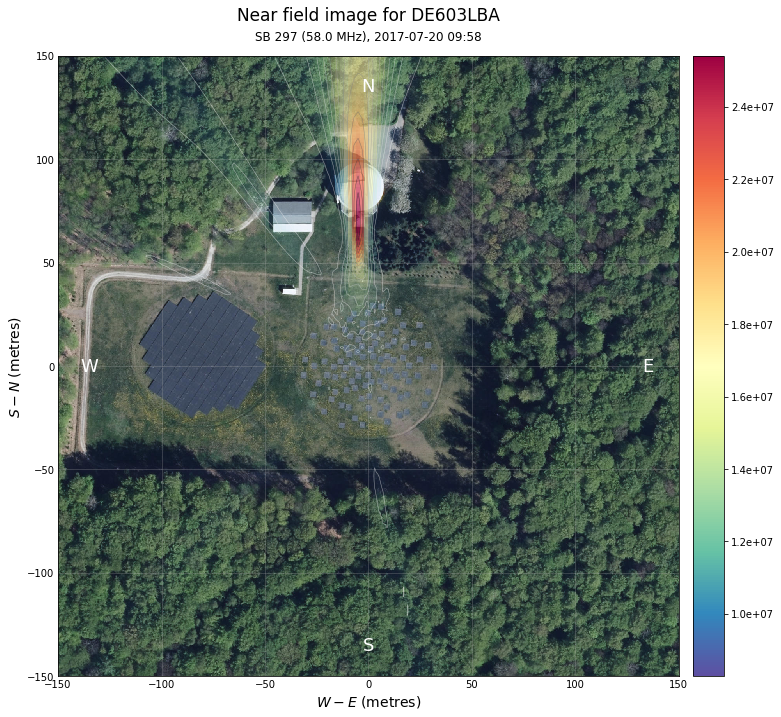

In [43]:
# Plot the resulting image
fig = plt.figure(figsize=(10, 10), constrained_layout=True)
ax = fig.add_subplot(111, ymargin=-0.4)
ax.imshow(background_map, extent=extent)
cimg = ax.imshow(img, origin='lower', cmap=cmap_with_alpha, extent=extent,
                 alpha=0.7, vmin=None, vmax=None)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2, axes_class=maxes.Axes)
cbar = fig.colorbar(cimg, cax=cax, orientation="vertical", format="%.1e")
cbar.set_alpha(1.0)
cbar.draw_all()
# cbar.set_ticks([])

ax.set_xlabel('$W-E$ (metres)', fontsize=14)
ax.set_ylabel('$S-N$ (metres)', fontsize=14)

ax.text(0.5, 1.05, f"Near field image for {station_name}",
        fontsize=17, ha='center', va='bottom', transform=ax.transAxes)
ax.text(0.5, 1.02, f"SB {subband} ({freq / 1e6:.1f} MHz), {str(obstime)[:16]}",
        fontsize=12, ha='center', va='bottom', transform=ax.transAxes)

# Change limits to match the original specified extent in the localnorth frame
ax.set_xlim(extent[0], extent[1])
ax.set_ylim(extent[2], extent[3])
ax.tick_params(axis='both', which='both', length=0)

# Place the NSEW coordinate directions
ax.text(0.95, 0.5, 'E', color='w', fontsize=18, transform=ax.transAxes, horizontalalignment='center', verticalalignment='center')
ax.text(0.05, 0.5, 'W', color='w', fontsize=18, transform=ax.transAxes, horizontalalignment='center', verticalalignment='center')
ax.text(0.5, 0.95, 'N', color='w', fontsize=18, transform=ax.transAxes, horizontalalignment='center', verticalalignment='center')
ax.text(0.5, 0.05, 'S', color='w', fontsize=18, transform=ax.transAxes, horizontalalignment='center', verticalalignment='center')

ground_vmin_img, ground_vmax_img = cimg.get_clim()
ax.contour(img, np.linspace(ground_vmin_img, ground_vmax_img, 15), origin='lower', cmap=cm.Greys,
           extent=extent, linewidths=0.5, alpha=0.6)
ax.grid(True, alpha=0.3)
plt.savefig(f"results/{fname}_nearfield_calibrated.png", bbox_inches='tight', dpi=200)

In [44]:
vmin, vmax = cimg.get_clim()
folium_overlay = cmap_with_alpha(Normalize(vmin=vmin, vmax=vmax)(img))[::-1, :]

In [45]:
maxpixel_ypix, maxpixel_xpix = np.unravel_index(np.argmax(img), img.shape)
maxpixel_x = np.interp(maxpixel_xpix, [0, npix_x], [extent[0], extent[1]])
maxpixel_y = np.interp(maxpixel_ypix, [0, npix_y], [extent[2], extent[3]])
[maxpixel_p, maxpixel_q, _] = pqr_to_xyz.T @ np.array([maxpixel_x, maxpixel_y, height])
maxpixel_lon, maxpixel_lat, _ = lofargeotiff.pqr_to_longlatheight([maxpixel_p, maxpixel_q], station_name)

In [46]:
# Show location of maximum if not at the image border
if 5 < maxpixel_xpix < npix_x - 5 and 5 < maxpixel_ypix < npix_y - 5:
    print(f"Maximum at {maxpixel_x:.0f}m east, {maxpixel_y:.0f}m north of station center (lat/long {maxpixel_lat:.5f}, {maxpixel_lon:.5f})")

Maximum at -6m east, 70m north of station center (lat/long 50.97998, 11.71118)


In [47]:
# Check total time to run
end1 = time.time()
print ('Time elapsed: %.2f s' % (end1-start1))

Time elapsed: 36.33 s


Export the near field image to GeoTIFF for archiving and viewing in other tools (QGIS).

In [48]:
obstime = datetime.datetime.strptime(obsdatestr + ":" + obstimestr, '%Y%m%d:%H%M%S')

In [49]:
tags = {"datafile": xst_filename,
        "generated_with": f"lofarimaging notebook",
        "caltable": caltable_filename,
        "subband": subband,
        "frequency": freq,
        "extent_xyz": extent,
        "height": height,
        "station": station_name,
        "pixels_per_metre": pixels_per_metre}
if caltable_filename is not None:
    if "CalTableHeader.Observation.Date" in cal_header:
        tags["calibration_obsdate"] =  cal_header["CalTableHeader.Observation.Date"]
    if "CalTableHeader.Calibration.Date" in cal_header:
        tags["calibration_date"] = cal_header["CalTableHeader.Calibration.Date"]
    if "CalTableHeader.Comment" in cal_header:
        tags["calibration_comment"] = cal_header["CalTableHeader.Comment"]
lofargeotiff.write_geotiff(img, f"results/{fname}_nearfield_calibrated.tiff",
                           (pmin, qmin), (pmax, qmax), stationname=station_name,
                           obsdate=obstime, tags=tags)

Overlay the near field image on a map.

In [50]:
make_leaflet_map(folium_overlay, lon_center, lat_center, lon_min, lat_min, lon_max, lat_max)